# Python for Stock Trading

Python has been gaining significant traction in the financial industry over the past years. We can leverage the powerful functionality provided by a number of Python packages like ``pandas`` and ``matplotlib`` to develop and backtest a quantitative trading strategy. Specifically, we can easily download financial data from free online databases, manipulate the downloaded data and then create some basic technical indicators are used as the basis of many quantitative strategy. 

In this notebook, we will show how to design a simple stock trading strategy based on moving average using python. Note that this is a rule-based trading strategy, and it involves no machine learning techniques.

**Disclaimer: This notebook does not constitute any investment advice.**

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Get the data

We will need the ``pandas_datareadear`` package to get market data from a free online source such as Google Finance.

``
pip install pandas_datareader
``

In [6]:
import pandas_datareader as pdr

We would like to fetch all stock data from 01/01/2021 until 12/31/2022 for Apple Inc. (AAPL).

In [7]:
ticker = 'AAPL'
start = '2021-01-01'
end = '2022-12-31'

Use ``pandas_reader.data.DataReader`` to load the data from Google Finance by setting ``data_source = 'stooq'``.

In [8]:
stock = pdr.data.DataReader(name = ticker, data_source ='stooq', start = start, end = end)

In [9]:
stock.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2022-12-30,128.410,129.9500,127.43,129.93,77034209.0
2022-12-29,127.990,130.4814,127.73,129.61,75703710.0
2022-12-28,129.670,131.0275,125.87,126.04,85438391.0
2022-12-27,131.380,131.4100,128.72,130.03,69007830.0
2022-12-23,130.920,132.4150,129.64,131.86,63814893.0
2022-12-22,134.352,134.5600,130.30,132.23,77852108.0
2022-12-21,132.980,136.8100,132.75,135.45,85927993.0
2022-12-20,131.390,133.2500,129.89,132.30,77432819.0
2022-12-19,135.110,135.2000,131.32,132.37,79592614.0


In [10]:
stock.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-08,130.861,131.061,128.698,130.482,1.064206e+08
2021-01-07,126.834,130.063,126.334,129.355,1.108936e+08
2021-01-06,126.195,129.485,124.889,125.108,1.569497e+08
2021-01-05,127.362,130.173,126.902,129.445,9.883730e+07
2021-01-04,131.937,132.027,125.268,127.880,1.450221e+08


We will use **open prices** only for our trading strategy.

In [11]:
data = stock.iloc[::-1]
data.drop(['Close', 'High', 'Low'], axis = 1, inplace= True)
data.head()

,Open,Volume
Date,,
2021-01-04,131.937,1.450221e+08
2021-01-05,127.362,9.883730e+07
2021-01-06,126.195,1.569497e+08
2021-01-07,126.834,1.108936e+08
2021-01-08,130.861,1.064206e+08


## Moving average

One of the oldest and simplest trading strategies that exist is the one that uses a moving average of the price (or returns) timeseries to proxy the recent trend of the price.

The idea is quite simple, yet powerful; if we use a (say) 100-day moving average of our price time-series, then a significant portion of the daily price noise will have been "averaged-out". Thus, we can can observe more closely the longer-term behaviour of the asset.

The so-called Exponential Moving Average (EMA) with the length of window (span) $M$ is defined as

$$\mathrm{EMA}(t) = (1-\alpha) \mathrm{EMA}(t-1) + \alpha p(t), \quad \mathrm{EMA}(t_0) = p(t_0)$$

where $p(t)$ is the price at time $t$ and $\alpha = \frac{2}{M+1}$ is called the decay parameter for the EMA.

For EMA calculations, we can use ``pandas``'s built-in ``ewm`` method.

In [12]:
data['5-day'] = data['Open'].ewm(span=5, adjust = False).mean()
data.head()

,Open,Volume,5-day
Date,,,
2021-01-04,131.937,1.450221e+08,131.937000
2021-01-05,127.362,9.883730e+07,130.412000
2021-01-06,126.195,1.569497e+08,129.006333
2021-01-07,126.834,1.108936e+08,128.282222
2021-01-08,130.861,1.064206e+08,129.141815


In [13]:
data['14-day'] = data['Open'].ewm(span=14, adjust = False).mean()
data.head()

,Open,Volume,5-day,14-day
Date,,,,
2021-01-04,131.937,1.450221e+08,131.937000,131.937000
2021-01-05,127.362,9.883730e+07,130.412000,131.327000
2021-01-06,126.195,1.569497e+08,129.006333,130.642733
2021-01-07,126.834,1.108936e+08,128.282222,130.134902
2021-01-08,130.861,1.064206e+08,129.141815,130.231715


Let us plot the three timeseries for Apple stock during 2015-2016, to get a feeling about how these behave. 

In [14]:
price = data['Open']
ema30 = data['14-day']
ema9 = data['5-day']

In [15]:
price.head()

Date
2021-01-04    131.937
2021-01-05    127.362
2021-01-06    126.195
2021-01-07    126.834
2021-01-08    130.861
Name: Open, dtype: float64

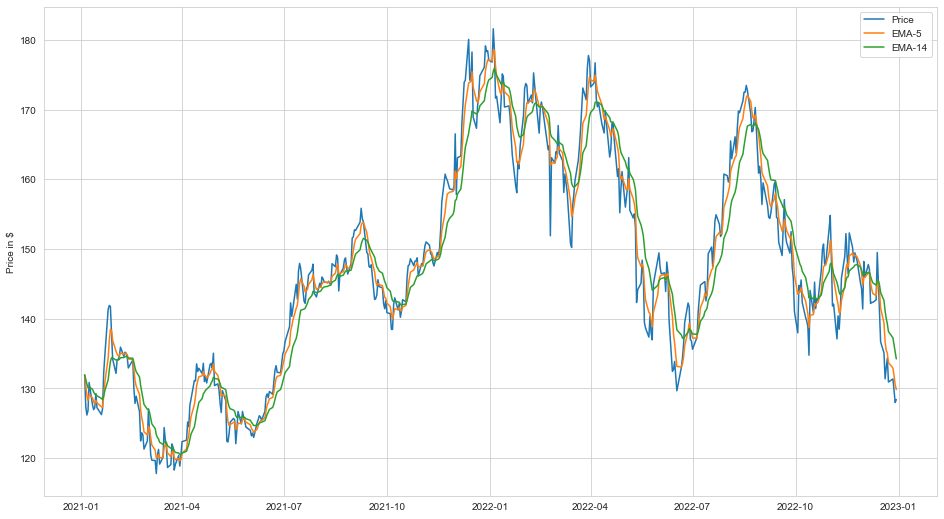

In [16]:
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(price, label = 'Price')
ax.plot(ema9, label = 'EMA-5')
ax.plot(ema30, label = 'EMA-14')


ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.grid(True)

## Trading strategy 

We use the moving averages calculated above to design a trading strategy by assuming that when a change in the long term behaviour of the stock occurs, the EMA-5 timeseries will react faster than the EMA-14 one. Therefore, we will consider the crossing of the two as potential trading signals.

1. When the EMA-5 timeseries crosses the EMA-14 timeseries from below, we will close any existing short position and go long (buy) one share of the stock at open price.

2. When the EMA-5 timeseries crosses the EMA-14 timeseries from above, we will close any existing long position and go short (sell) one share of the stock at open price.

#### Add 'signal' column

``signal`` = 1 means an uptrend with EMA5(t) > EMA14(t) and ``signal`` = -1 means a downtrend with EMA5(t) < EMA14(t).

In [17]:
data['signal'] = np.where(data['5-day'] > data['14-day'], 1, 0)
data.head()

,Open,Volume,5-day,14-day,signal
Date,,,,,
2021-01-04,131.937,1.450221e+08,131.937000,131.937000,0
2021-01-05,127.362,9.883730e+07,130.412000,131.327000,0
2021-01-06,126.195,1.569497e+08,129.006333,130.642733,0
2021-01-07,126.834,1.108936e+08,128.282222,130.134902,0
2021-01-08,130.861,1.064206e+08,129.141815,130.231715,0


In [27]:
data['signal'] = np.where(data['5-day'] < data['14-day'], -1, data['signal'])
data.head()

,Open,Volume,5-day,14-day,signal,return,strategy_return,entry
Date,,,,,,,,
2021-01-04,131.937,1.450221e+08,131.937000,131.937000,0,-0.035291,-0.000000,NaN
2021-01-05,127.362,9.883730e+07,130.412000,131.327000,-1,-0.009205,0.009205,-1.0
2021-01-06,126.195,1.569497e+08,129.006333,130.642733,-1,0.005051,-0.005051,0.0
2021-01-07,126.834,1.108936e+08,128.282222,130.134902,-1,0.031257,-0.031257,0.0
2021-01-08,130.861,1.064206e+08,129.141815,130.231715,-1,-0.024765,0.024765,0.0


## Calculate returns

The widely-used (log) return on any day $t$ is defined as 

$$
\log \frac{p(t)}{p(t-1)} = \log(p(t)) -\log(p(t-1))
$$

We compare the return given by our EMA based strategy with that of the naive buy and hold one. We will first calculate the daily returns and then the accumulated returns.

For example, if we buy and hold on day 1 until day $T$, then the accumlated return in log scale is

$$
\log \frac{p(T)}{p(1)} = \log \prod_{t= 2}^T \frac{p(t)}{p(t-1)} = \sum_{t= 2}^T  \log \frac{p(t)}{p(t-1)} 
$$

In [28]:
data['return'] = -np.log(data['Open']).diff(-1)
data.head(10)

,Open,Volume,5-day,14-day,signal,return,strategy_return,entry
Date,,,,,,,,
2021-01-04,131.937,1.450221e+08,131.937000,131.937000,0,-0.035291,-0.000000,NaN
2021-01-05,127.362,9.883730e+07,130.412000,131.327000,-1,-0.009205,0.009205,-1.0
2021-01-06,126.195,1.569497e+08,129.006333,130.642733,-1,0.005051,-0.005051,0.0
2021-01-07,126.834,1.108936e+08,128.282222,130.134902,-1,0.031257,-0.031257,0.0
2021-01-08,130.861,1.064206e+08,129.141815,130.231715,-1,-0.024765,0.024765,0.0
2021-01-11,127.660,1.018288e+08,128.647877,129.888820,-1,-0.005404,0.005404,0.0
2021-01-12,126.972,9.305496e+07,128.089251,129.499911,-1,0.002046,-0.002046,0.0
2021-01-13,127.232,8.970086e+07,127.803501,129.197522,-1,0.015628,-0.015628,0.0
2021-01-14,129.236,9.130481e+07,128.281000,129.202653,-1,-0.015471,0.015471,0.0


In [29]:
data['strategy_return'] = data['return']*data['signal']
data.head()

,Open,Volume,5-day,14-day,signal,return,strategy_return,entry
Date,,,,,,,,
2021-01-04,131.937,1.450221e+08,131.937000,131.937000,0,-0.035291,-0.000000,NaN
2021-01-05,127.362,9.883730e+07,130.412000,131.327000,-1,-0.009205,0.009205,-1.0
2021-01-06,126.195,1.569497e+08,129.006333,130.642733,-1,0.005051,-0.005051,0.0
2021-01-07,126.834,1.108936e+08,128.282222,130.134902,-1,0.031257,-0.031257,0.0
2021-01-08,130.861,1.064206e+08,129.141815,130.231715,-1,-0.024765,0.024765,0.0


We act only when the trend changes, i.e., ``signal`` changes from -1 to 1, or from 1 to -1. To catch the trend, we create a ``entry`` column taking the difference between any two consecutive signals.

In [30]:
data['entry'] = data['signal'].diff()
data.head(10)

,Open,Volume,5-day,14-day,signal,return,strategy_return,entry
Date,,,,,,,,
2021-01-04,131.937,1.450221e+08,131.937000,131.937000,0,-0.035291,-0.000000,NaN
2021-01-05,127.362,9.883730e+07,130.412000,131.327000,-1,-0.009205,0.009205,-1.0
2021-01-06,126.195,1.569497e+08,129.006333,130.642733,-1,0.005051,-0.005051,0.0
2021-01-07,126.834,1.108936e+08,128.282222,130.134902,-1,0.031257,-0.031257,0.0
2021-01-08,130.861,1.064206e+08,129.141815,130.231715,-1,-0.024765,0.024765,0.0
2021-01-11,127.660,1.018288e+08,128.647877,129.888820,-1,-0.005404,0.005404,0.0
2021-01-12,126.972,9.305496e+07,128.089251,129.499911,-1,0.002046,-0.002046,0.0
2021-01-13,127.232,8.970086e+07,127.803501,129.197522,-1,0.015628,-0.015628,0.0
2021-01-14,129.236,9.130481e+07,128.281000,129.202653,-1,-0.015471,0.015471,0.0


We change the position from short to long if ``entry``= 2 and from long to short if ``entry`` = -2.

In [31]:
long = data[['Open']][data['entry'] == 2]
long.tail(10)

,Open
Date,
2021-10-19,145.935
2022-02-01,173.012
2022-03-22,164.768
2022-06-01,149.444
2022-06-08,148.128
2022-06-27,142.261
2022-07-06,140.925
2022-10-24,146.941
2022-11-14,148.970


In [32]:
short = data[['Open']][data['entry'] == -2]
short.head()

,Open
Date,
2021-02-12,132.944
2021-05-05,127.860
2021-09-15,147.480
2022-01-07,171.896
2022-02-18,169.055


In [33]:
short.tail(10)

,Open
Date,
2022-01-07,171.896
2022-02-18,169.055
2022-04-12,167.260
2022-06-07,143.906
2022-06-10,139.853
2022-06-30,136.833
2022-08-29,160.878
2022-11-04,142.090
2022-11-29,144.290


Plot trades on time series during years 2021-2022:

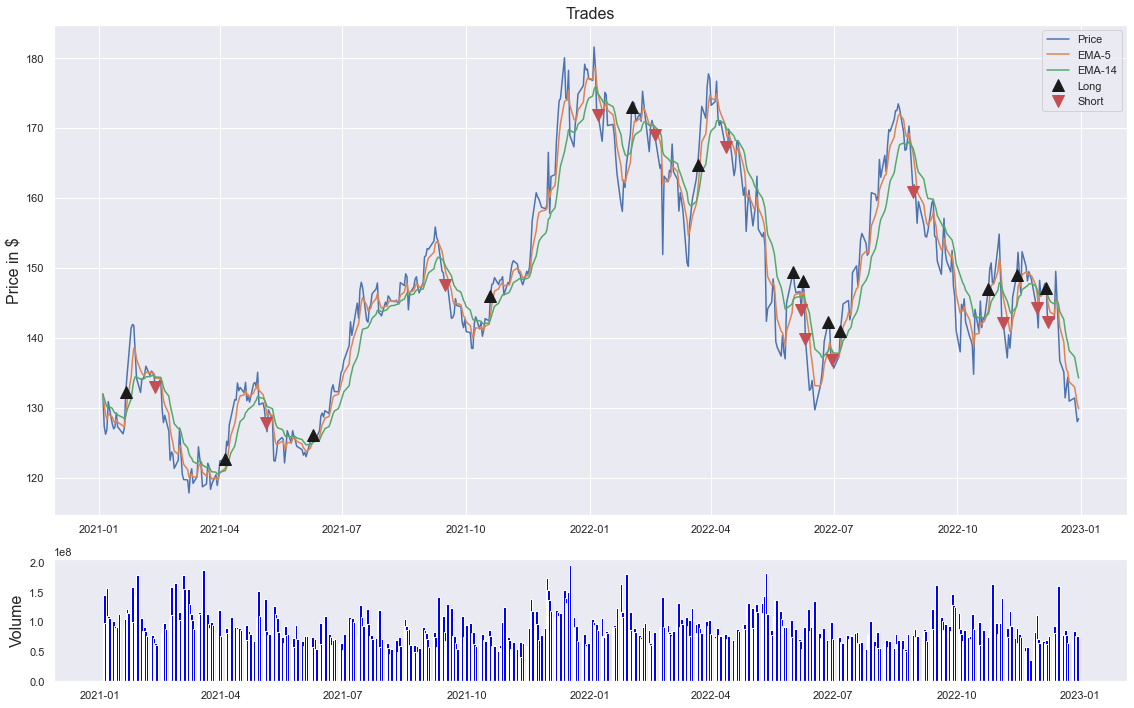

In [34]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [4, 1]}, figsize = (16,10))
fig.tight_layout(pad=2)

ax[0].plot(price, label = 'Price')
ax[0].plot(ema9, label = 'EMA-5')
ax[0].plot(ema30, label = 'EMA-14')
ax[0].plot(long, '^', color = 'k', markersize= 12, label = 'Long')
ax[0].plot(short, 'v', color = 'r', markersize= 12, label = 'Short')

ax[0].legend(loc='best')
# ax[0].set_xticks([])
ax[0].set_ylabel('Price in $', fontsize = 16)
ax[0].set_title('Trades', fontsize = 16)


ax[1].bar(data.index, height = data['Volume'], width=2, color='blue')
ax[1].set_ylabel('Volume', fontsize = 16)
ax[1].grid(False)

Plot the accumulated return rates (in regular scale) over the trading period. Here we use the relation

$$
\frac{p(T)}{p(1)} = \prod_{t=2}^T \exp \left(\log \frac{p(t)}{p(t-1)}\right)
$$



Text(0.5, 1.0, 'Returns')

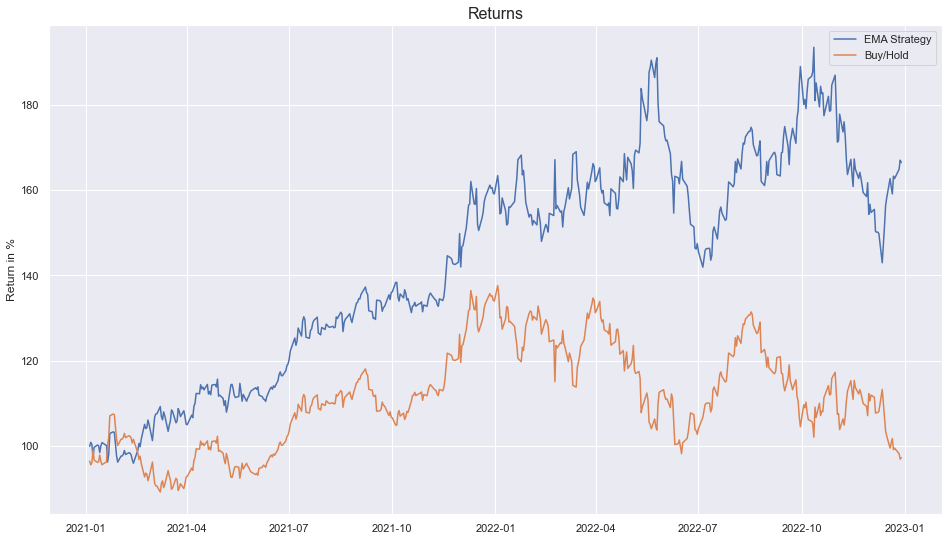

In [26]:
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(100*np.exp(data['strategy_return']).cumprod(), label = 'EMA Strategy')
ax.plot(100*np.exp(data['return']).cumprod(), label = 'Buy/Hold')

ax.legend(loc='best')
ax.set_ylabel('Return in %')
ax.set_title('Returns', fontsize = 16)

**Remark**: In practice, factors that take away the profit should be taken into account, such as commission fees and paid interets on an open short position.